In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

http://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

http://ucanalytics.com/blogs/arima-models-manufacturing-case-study-example-part-3/

https://stats.stackexchange.com/questions/23036/estimating-same-model-over-multiple-time-series

The idea with ARIMA models is that the final residual should look like white noise otherwise, there is juice or information available in the data to extract

In [51]:
from __future__ import division
from os import path, remove
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from sklearn.metrics import r2_score
from fastdtw import fastdtw
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from pandas import read_csv
from pandas import datetime
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from price_history import PriceHistory
from arima.arima_estimator import ArimaEstimator
import warnings
from collections import OrderedDict

In [3]:
%matplotlib inline

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.

In [4]:
data_path = '../../../../../Dropbox/data'

In [5]:
score_dic_filepath = data_path + "/arima/scoredic_non_stationary.npy"

In [6]:
ph_data_path = data_path + '/price_history'

In [7]:
csv_in = "../price_history_03_seq_start_suddens_trimmed.csv"

In [11]:
ph = PriceHistory(csv_in)

In [12]:
seqs = ph.extractAllSequences()

In [13]:
def custom_transformation(sequence, window):
    #logged_vals = np.log(sequence.values)
    logged_vals = sequence.values
    logged_seq = sequence.copy()
    logged_seq[logged_seq.index] = logged_vals
    return logged_seq - logged_seq.rolling(window=window).mean()

In [43]:
orig_seq = seqs[0]

In [21]:
window = 3

In [22]:
seq_tr = custom_transformation(sequence=seqs[0], window=window)

In [60]:
np.all(seq_tr == seq_tr)

False

In [62]:
seq = seq_tr[window-1:]

In [63]:
np.all(seq == seq)

True

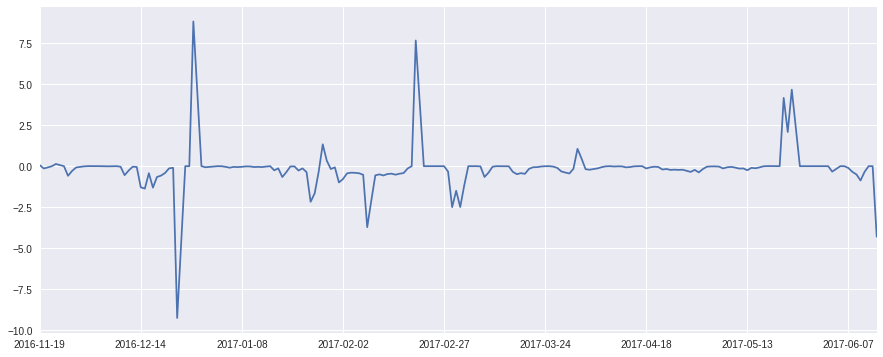

In [64]:
plt.figure(figsize=(15,6))
seq.plot()
plt.show()

In [65]:
ae = ArimaEstimator(p_auto_regression_order=4, d_integration_level=1, q_moving_average=3, easy_mode=False)

In [66]:
target_len = 30

In [67]:
XX = seq[:-target_len].values.reshape((1, -1))
XX.shape

(1, 178)

In [68]:
YY = seq[-target_len:].values.reshape((1, -1))
YY.shape

(1, 30)

In [69]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ae.fit(inputs=XX, targets=YY)

CPU times: user 7.16 s, sys: 7.36 s, total: 14.5 s
Wall time: 6.33 s


In [70]:
preds = ae.preds.flatten()
yy = YY.flatten()
yy.shape, preds.shape

((30,), (30,))

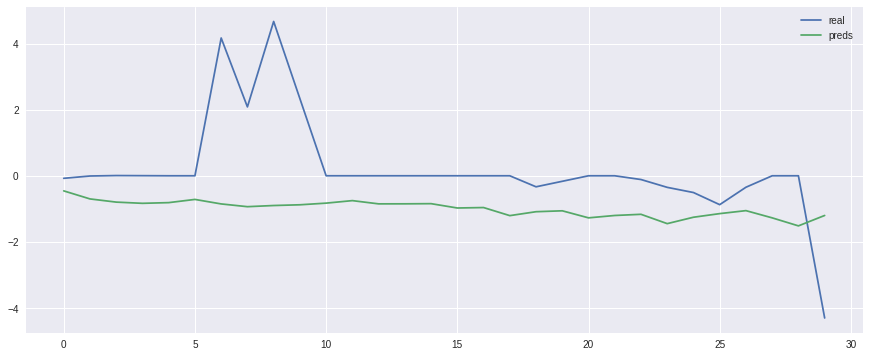

In [71]:
plt.figure(figsize=(15,6))
plt.plot(yy, label='real')
plt.plot(preds, label='preds')
plt.legend()
plt.show()

### Reverse Moving average
https://stats.stackexchange.com/questions/67907/extract-data-points-from-moving-average

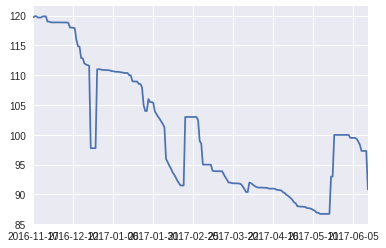

In [72]:
orig_seq.plot()

In [99]:
aa = np.zeros((orig_seq.size - window +1, orig_seq.size))
aa.shape

(208, 210)

In [100]:
for ii, item in enumerate(aa):
    aa[ii, ii:ii+window] = 1/window

In [101]:
trans1 = aa.dot(orig_seq)
trans1.shape

(208,)

In [102]:
from numpy.linalg import pinv

In [103]:
trans2 = orig_seq.rolling(window=window).mean()[window-1:].values
trans2.shape

(208,)

In [104]:
np.allclose(trans1, trans2)

True

In [105]:
pA = pinv(aa)
pA.shape

(210, 208)

In [107]:
reconstructed = pA.dot(trans1)
reconstructed.shape

(210,)

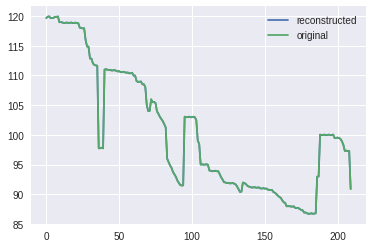

In [112]:
plt.plot(reconstructed, label='reconstructed')
plt.plot(orig_seq.values, label='original')
plt.legend()
plt.show()

In [121]:
np.allclose(reconstructed, orig_seq.values, rtol=1e-3)

True

In [128]:
#np.sqrt(np.mean((reconstructed - orig_seq.values)**2)) #RMSE
np.corrcoef(orig_seq.values, reconstructed)

array([[ 1.        ,  0.99998796],
       [ 0.99998796,  1.        ]])

#### Conclusion
That is great we have managed to recover the moving average  
Now let's see if we can recover the subtracted moving average

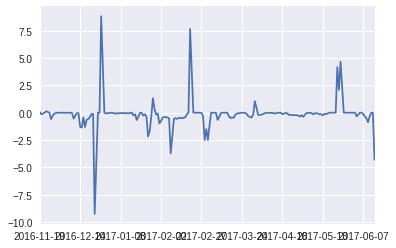

In [129]:
seq.plot()

In [176]:
bb_orig = 1 - aa

In [178]:
#np.all(bb_orig == bb)

In [191]:
representative = np.ones(len(aa))[np.newaxis].T
representative[-(window -1):, :] = 0
representative[:window + 3], representative[-(window + 3):]

(array([[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.]]), array([[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 0.]]))

In [192]:
bb = representative - aa
print bb.shape
bb

(208, 210)


array([[ 0.66666667,  0.66666667,  0.66666667, ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  0.66666667,  0.66666667, ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  0.66666667, ...,  1.        ,
         1.        ,  1.        ],
       ..., 
       [ 1.        ,  1.        ,  1.        , ...,  0.66666667,
         1.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.33333333,
        -0.33333333,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.33333333,
        -0.33333333, -0.33333333]])

In [193]:
pOneMinusA = pinv(bb)
pOneMinusA.shape

(210, 208)

In [194]:
custom_recons = pOneMinusA.dot(seq.values)
custom_recons.shape

(210,)

In [195]:
np.allclose(custom_recons, orig_seq.values, rtol=1e-3)

False

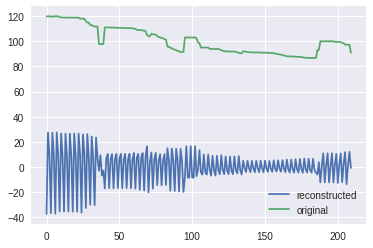

In [196]:
plt.plot(custom_recons, label='reconstructed')
plt.plot(orig_seq.values, label='original')
plt.legend()
plt.show()

#### WTF What is going on ??

In [144]:
np.corrcoef(orig_seq.values, custom_recons)

array([[  1.00000000e+00,  -1.00888560e-04],
       [ -1.00888560e-04,   1.00000000e+00]])

In [165]:
aa.shape, orig_seq.values.shape

((208, 210), (210,))

In [157]:
trans4 = orig_seq.values[window-1:] - aa.dot(orig_seq.values)
np.allclose(trans4, seq.values)

True

In [166]:
bb = 1 - aa
bb.shape

(208, 210)

In [171]:
trans3 = bb.dot(orig_seq.values)
trans3.shape

(208,)

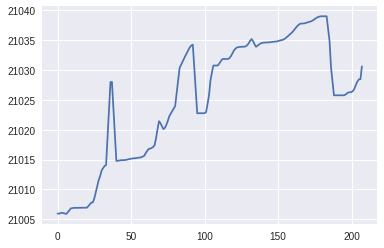

In [172]:
plt.plot(trans3)
#plt.plot(orig_seq.values)

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

In [27]:
parameters = OrderedDict([
    ('p_auto_regression_order', range(6)), #0-5
    ('d_integration_level', range(3)), #0-2
    ('q_moving_average', range(6)), #0-5
])

In [28]:
def cartesian_coord(*arrays):
    grid = np.meshgrid(*arrays)        
    coord_list = [entry.ravel() for entry in grid]
    points = np.vstack(coord_list).T
    return points

In [29]:
cart = cartesian_coord(*parameters.values())
cart.shape

(108, 3)

In [30]:
108 * 15 / 60 / 2 #in hours!

13.5

In [31]:
count_inds=100
random_state = np.random.RandomState(seed=16011984)

In [32]:
random_inds = random_state.choice(range(len(XX)), count_inds, replace=False)
xx = XX[random_inds]
yy = YY[random_inds]

In [33]:
filepath = 'scoredic.npy'

In [34]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for pp, dd, qq in cart:
        scoredic = np.load(filepath)[()] if path.isfile(filepath) else OrderedDict()
        cur_tuple = (pp, dd, qq)
        if cur_tuple in scoredic:
            continue
        else:
            ae = ArimaEstimator(p_auto_regression_order=pp, d_integration_level=dd, q_moving_average=qq,
                                easy_mode=True)
            scoredic[cur_tuple] = ae.fit(inputs=xx, targets=yy).score(xx, yy)
            np.save(filepath, scoredic)

KeyboardInterrupt: 

In [77]:
from sklearn.model_selection import GridSearchCV

In [79]:
# Pick hyperparameters
# There is NO separation of training and testing set because there is no transfer of knowledge from the training 
# that could be useful for validation
# Run Arima prediction steps for all instances of training dataset and get a fastdtw score from each case
# Get the mean of the fastdtw and this is the CV score
# 
# Do this for all possible parameters

In [76]:
fitted = model.fit()

In [ ]:
fitted.

In [29]:
model_fit = model.fit(disp=0)

In [30]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          ARIMA Model Results                                          
=======================================================================================================
Dep. Variable:     D.Sales of shampoo over a three year period   No. Observations:                   35
Model:                                          ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                                                css-mle   S.D. of innovations             64.241
Date:                                         Wed, 19 Jul 2017   AIC                            406.340
Time:                                                 19:38:55   BIC                            417.227
Sample:                                             02-01-1901   HQIC                           410.098
                                                  - 12-01-1903                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                                12.0649      3.652      3.304      0.003       4.908      19.222
ar.L1.D.Sales of shampoo over a three year period    -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.Sales of shampoo over a three year period    -0.6203      0.282     -2.203      0.036      -1.172      -0.068
ar.L3.D.Sales of shampoo over a three year period    -0.3606      0.295     -1.222      0.231      -0.939       0.218
ar.L4.D.Sales of shampoo over a three year period    -0.1252      0.280     -0.447      0.658      -0.674       0.424
ar.L5.D.Sales of shampoo over a three year period     0.1289      0.191      0.673      0.506      -0.246       0.504
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0617           -0.5064j            1.1763           -0.4292
AR.2           -1.0617           +0.5064j            1.1763            0.4292
AR.3            0.0816           -1.3804j            1.3828           -0.2406
AR.4            0.0816           +1.3804j            1.3828            0.2406
AR.5            2.9315           -0.0000j            2.9315           -0.0000
-----------------------------------------------------------------------------
"""

In [31]:
residuals = DataFrame(model_fit.resid)

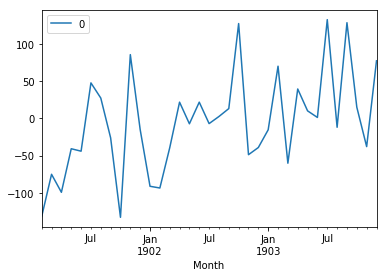

In [72]:
residuals.plot()
plt.show()

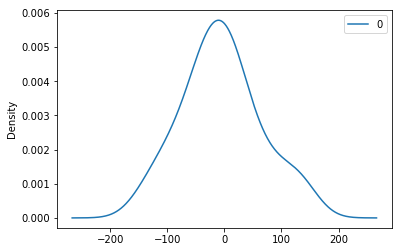

In [71]:
residuals.plot(kind='kde')
plt.show()

In [34]:
residuals.describe()

,0
count,35.000000
mean,-5.495203
std,68.132882
min,-133.296589
25%,-42.477874
50%,-7.186603
75%,24.748348
max,133.237993


# Train - Test

In [60]:
XX = series.values
XX.shape

(36,)

In [61]:
#splitting
train_size = int(len(XX)*2/3)
train_size

24

In [62]:
train_set = XX[:train_size]
test_set = XX[train_size:]
train_set.shape, test_set.shape

((24,), (12,))

In [63]:
train_set[0]

266.0

In [64]:
history = list(train_set)

In [65]:
history[0] = 3333

In [66]:
history = list(train_set)
len(history)

24

In [67]:
predictions = []

In [68]:
for tt in range(len(test_set)):
    output = ARIMA(history, order=(5,1,0)).fit(disp=0).forecast()
    y_hat = output[0] #0th is the index of the prediction
    predictions.append(y_hat)
    
    observation = test_set[tt]
    #history.append(observation)
    history.append(y_hat)
    
    print "predicted: {}, expected: {}".format(y_hat, observation)

predicted: [ 306.51287642], expected: 339.7
predicted: [ 389.00679733], expected: 440.4
predicted: [ 340.99243533], expected: 315.9
predicted: [ 370.26296951], expected: 439.3
predicted: [ 347.42978471], expected: 401.3
predicted: [ 389.06447038], expected: 437.4
predicted: [ 378.3640104], expected: 575.5
predicted: [ 397.62612576], expected: 407.6
predicted: [ 387.34007046], expected: 682.0
predicted: [ 407.76038113], expected: 475.3
predicted: [ 408.07287879], expected: 581.3
predicted: [ 422.86599266], expected: 646.9


In [69]:
error = mean_squared_error(predictions, test_set)
error

18743.644548971621

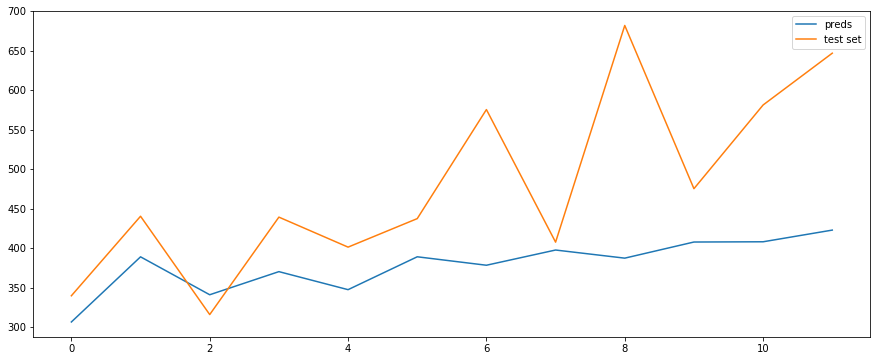

In [70]:
plt.figure(figsize=(15,6))
plt.plot(predictions, label='preds')
plt.plot(test_set, label='test set')
plt.legend()
plt.show()